#### Global Modules

In [826]:
import pandas as pd
from datetime import datetime, date
from typing import Optional
from pandas import DataFrame, Series

#### Local Modules

In [827]:
from nwtimetracking import SettingBag, ComponentBag, TimeTrackingProcessor, OPTION, TTSummary

#### Settings

In [828]:
setting_bag : SettingBag = SettingBag(
    options_tt = [OPTION.display],
    options_tts_by_month = [OPTION.display, OPTION.save],
    options_tts_by_year = [OPTION.display],
    options_tts_by_year_month = [OPTION.display],
    options_tts_by_year_month_spnv = [OPTION.display],
    options_tts_by_year_spnv = [OPTION.display],
    options_tts_by_spn = [OPTION.display, OPTION.log],
    options_tts_by_spn_spv = [],
    options_tts_by_hashtag = [OPTION.display],
    options_tts_by_hashtag_year = [OPTION.display],
    options_tts_by_efs = [OPTION.display],
    options_tts_by_tr = [OPTION.display],
    options_definitions = [OPTION.display],
    excel_nrows = 1328,
    tts_by_year_month_spnv_display_only_spn = "nwtimetracking",
    tts_by_year_spnv_display_only_spn = "nwtimetracking",
    tts_by_spn_spv_display_only_spn = "nwtimetracking",
    md_enable_github_optimizations = True
)


#### Main : Analysis

In [829]:
tt_processor : TimeTrackingProcessor = TimeTrackingProcessor(component_bag = ComponentBag(), setting_bag = setting_bag)
tt_processor.initialize()
tt_processor.process_tt()

Date,StartTime,EndTime,Effort,Hashtag,Descriptor,IsSoftwareProject,IsReleaseDay,Year,Month
2024-12-16,09:00,19:30,10h 30m,#python,nwtimetracking v4.5.0,True,False,2024,12
2024-12-16,21:00,22:30,1h 30m,#python,nwtimetracking v4.5.0,True,False,2024,12
2024-12-17,10:00,11:00,1h 00m,#python,nwtimetracking v4.5.0,True,False,2024,12
2024-12-17,12:00,15:30,3h 30m,#python,nwtimetracking v4.5.0,True,False,2024,12
2024-12-17,16:30,18:30,2h 00m,#python,nwtimetracking v4.5.0,True,False,2024,12


In [ ]:
from datetime import timedelta
import re
from typing import Any, Callable, Literal, Union, cast
from dateutil.relativedelta import relativedelta
from enum import StrEnum
from numpy import uint
from pandas import Timestamp
from dataclasses import dataclass, field
from datetime import timedelta
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

class TTCN(StrEnum):

    DATE = "Date"
    STARTTIME = "StartTime"
    ENDTIME = "EndTime"
    EFFORT = "Effort"
    HASHTAG = "Hashtag"
    DESCRIPTOR = "Descriptor"
    ISSOFTWAREPROJECT = "IsSoftwareProject"
    ISRELEASEDAY = "IsReleaseDay"
    YEAR = "Year"
    MONTH = "Month"
    PROJECTNAME = "ProjectName"
    PROJECTVERSION = "ProjectVersion"
    DME = "DME"
    TME = "TME"
    DYE = "DYE"
    TYE = "TYE"
    TREND = "↕"
    EFFORTPERC = "Effort%"
    YEARLYTARGET = "YearlyTarget"
    TARGETDIFF = "TargetDiff"
    ISTARGETMET = "IsTargetMet"
    YEARLYTOTAL = "YearlyTotal"
    TOTARGET = "ToTarget"
    PERCDME = "%_DME"
    PERCTME = "%_TME"
    PERCDYE = "%_DYE"
    PERCTYE = "%_TYE"
    DE = "DE"
    TE = "TE"
    PERCDE = "%_DE"
    PERCTE = "%_TE"
    EFFORTSTATUS = "EffortStatus"
    ESISCORRECT = "ES_IsCorrect"
    ESEXPECTED = "ES_Expected"
    ESMESSAGE = "ES_Message"
    TIMERANGEID = "TimeRangeId"
    OCCURRENCES = "Occurrences"

    # NEW
    STARTDATE = "StartDate"
    ENDDATE = "EndDate"
    DURATION = "Duration"
    EFFORTH = "EffortH"
    SEQRANK = "SeqRank"
    HASHTAGSEQ = "HashtagSeq"

def unbox_effort(effort : str) -> timedelta:

    '''"5h 30m" => 5:30:00'''

    unboxed : timedelta = pd.Timedelta(value = effort).to_pytimedelta()

    return unboxed
def box_effort(effort : timedelta, add_plus_sign : bool = False) -> str:

    '''
        4 days 19:15:00	=> "115h 15m" (or +115h 15m)
        -9 days +22:30:00 => "-194h 30m"
    '''

    total_seconds : float = effort.total_seconds()
    hours : int = int(total_seconds // 3600)
    minutes : int = int((total_seconds % 3600) // 60)

    hours_str : str = str(hours).zfill(2)
    minutes_str : str = str(minutes ).zfill(2)

    boxed : str = f"{hours_str}h {minutes_str}m"

    if (add_plus_sign == True and effort.days >= 0):
        boxed = f"+{boxed}"

    return boxed
def extract_software_project_name(descriptor : str) -> str:

    '''
        "NW.AutoProffLibrary v1.0.0"    => "NW.AutoProffLibrary"
        "nwreadinglistmanager v1.5.0"   => "nwreadinglistmanager"

        Returns "ERROR" is parsing goes wrong.
    '''

    pattern : str = r"\b[a-zA-Z\.]{2,}(?=[ v]{2}[0-9]{1}[\.]{1}[0-9]{1}[\.]{1}[0-9]{1})"
    matches : list = re.findall(pattern = pattern, string = descriptor, flags = re.MULTILINE)

    if len(matches) == 1:
        return matches[0]

    return "ERROR"
def calculate_from_start_date(now : datetime, months : int) -> Optional[date]:
    
    """Calculate from_start_date as now minus window_size months."""

    if months < 1:
        return None

    try:

        from_start_date : datetime = now - relativedelta(months = months)
  
        return from_start_date.date()
    
    except:
        return None
def round_effort(effort : str) -> int:

    '''
        14h 00m -> 14
        34h 15m -> 34
        13h 30m -> 13
        31h 45m -> 31 -> 32
    '''

    components : list[str] = effort.split()
    hour_str : str = components[0]
    minute_str : str = components[1]

    hours : int = int(hour_str.replace("h", ""))

    if "45m" in minute_str:
        hours += 1

    return hours
def filter_by_from_start_date(df : DataFrame, from_start_date : date, sort_by : Literal[TTCN.DESCRIPTOR, TTCN.HASHTAGSEQ]) -> DataFrame:

    '''Filters out a df according to the condition: TTCN.STARTDATE > from_start_date.'''

    filtered_df : DataFrame = df.copy(deep = True)

    condition : Series = (filtered_df[TTCN.STARTDATE] > pd.Timestamp(from_start_date))
    filtered_df = cast(DataFrame, filtered_df.loc[condition])
    filtered_df = filtered_df.sort_values(by = [sort_by, TTCN.STARTDATE]).reset_index(drop = True)

    return filtered_df
def filter_by_is_software_project(df : DataFrame, value : bool = True, spns : Optional[list[str]] = None) -> DataFrame:
    
    '''
        Filters out a df according to the condition: TTCN.ISSOFTWAREPROJECT == <value>.

        If spns is not None, only the listed software projects will be considered.    
    '''

    filtered_df : DataFrame = df.copy(deep = True)

    condition : Series = (filtered_df[TTCN.ISSOFTWAREPROJECT] == value)
    filtered_df = cast(DataFrame, filtered_df.loc[condition])

    if spns:
        filtered_df[TTCN.PROJECTNAME] = filtered_df[TTCN.DESCRIPTOR].apply(lambda x : extract_software_project_name(descriptor = x))
        condition = (filtered_df[TTCN.PROJECTNAME].isin(cast(list[str], spns)))
        filtered_df = cast(DataFrame, filtered_df.loc[condition])
        filtered_df.drop(columns = [TTCN.PROJECTNAME], inplace = True)

    filtered_df.reset_index(drop = True, inplace = True)

    return filtered_df
def filter_by_duration(df : DataFrame, min_duration : int) -> DataFrame:
    
    '''Filters out a df according to the condition: [TTCN.DURATION] >= min_duration.'''

    filtered_df : DataFrame = df.copy(deep = True)

    condition : Series = (filtered_df[TTCN.DURATION] >= min_duration)
    filtered_df = cast(DataFrame, filtered_df.loc[condition])

    filtered_df.reset_index(drop = True, inplace = True)

    return filtered_df

def create_gannt_df(df : DataFrame, group_by : Literal[TTCN.DESCRIPTOR, TTCN.HASHTAGSEQ]) -> DataFrame:

    '''
        Returns a df with the following columns: ["Descriptor", "StartDate", "EndDate", "Duration", "Effort"].
        
        Steps:
            1 -> [ "Date", "StartTime", "EndTime", "Effort", "Hashtag", "Descriptor", "IsSoftwareProject", "IsReleaseDay", "Year", "Month" ]
            2 -> ["Descriptor", "StartDate", "EndDate", "Effort"] ("Effort" as timedelta)
            3 -> ["Descriptor", "StartDate", "EndDate", "Effort", "Duration"] ("Effort" as timedelta)
            4 -> ["Descriptor", "StartDate", "EndDate", "Effort", "Duration"] ("Effort" as rounded int)
    '''

    gantt_df : DataFrame = df.copy(deep = True)
    gantt_df[TTCN.EFFORTH] = gantt_df[TTCN.EFFORT].apply(unbox_effort)
    
    gantt_df = (
        gantt_df
        .groupby(group_by)
        .agg(
            StartDate = (TTCN.DATE, 'min'), 
            EndDate = (TTCN.DATE, 'max'),
            EffortH = (TTCN.EFFORTH, 'sum'))
        .reset_index()
    )

    gantt_df[TTCN.STARTDATE] = pd.to_datetime(gantt_df[TTCN.STARTDATE])
    gantt_df[TTCN.ENDDATE] = pd.to_datetime(gantt_df[TTCN.ENDDATE])
    gantt_df[TTCN.DURATION] = (gantt_df[TTCN.ENDDATE] - gantt_df[TTCN.STARTDATE]).astype("timedelta64[ns]").dt.days

    gantt_df[TTCN.EFFORTH] = gantt_df[TTCN.EFFORTH].apply(box_effort)
    gantt_df[TTCN.EFFORTH] = gantt_df[TTCN.EFFORTH].apply(round_effort)

    gantt_df.reset_index(drop = True, inplace = True)

    return gantt_df
def show_gantt_chart(
        df : DataFrame, 
        fig_size : Tuple[int, int] = (10, 6), 
        title : Optional[str] = None, 
        x_label : Optional[str] = None, 
        y_label : Optional[str] = None,
        barh_y : Literal[TTCN.DESCRIPTOR, TTCN.HASHTAGSEQ] = TTCN.DESCRIPTOR
        ) -> None:
    
    """
        Expects:
            - ["Descriptor", "StartDate", "EndDate", "Duration", "Effort"]
            - ["HashtagSeq", "StartDate", "EndDate", "Duration", "Effort"]

        It shows a gannt chart out of df.
    """

    fig, ax = plt.subplots(figsize = fig_size)

    x_min : float = mdates.date2num(df[TTCN.STARTDATE].min()) - 5
    x_max : float = (mdates.date2num(df[TTCN.ENDDATE].max()) + 5)
    ax.set_xlim(xmin = x_min, xmax = x_max)

    y_min : float = -2.5
    y_max : float = len(df) + 2.5
    ax.set_ylim(ymin = y_min, ymax = y_max)

    for row_number, row in enumerate(df.itertuples()):

        row_caller : Any = getattr(row, barh_y)
        ax.barh(row_caller, row.Duration, left = row.StartDate, color = "skyblue", edgecolor = "black")

        ax.plot([row.EndDate, row.EndDate], [row_number - 0.4, row_number + 0.8], linestyle = "dotted", color = "black")
        formatted_date : str = f"{cast(datetime, row.EndDate).strftime("%Y-%m-%d")}"
        ax.text(
            mdates.date2num(row.EndDate),
            row_number + 0.8, 
            formatted_date, 
            ha = "center", 
            va = "bottom", 
            fontsize = 6, 
            rotation = 90,
            clip_on = True
        )

        if barh_y == TTCN.HASHTAGSEQ:
            ax.plot([row.StartDate, row.StartDate], [row_number - 0.4, row_number + 0.8], linestyle = "dotted", color = "black")
            formatted_date = f"{cast(datetime, row.StartDate).strftime("%Y-%m-%d")}"
            ax.text(
                mdates.date2num(row.StartDate), 
                row_number + 0.8, 
                formatted_date, 
                ha = "center", 
                va = "bottom", 
                fontsize = 6, 
                rotation = 90,
                clip_on = True
            )


        mid_point : datetime = cast(datetime, row.StartDate) + timedelta(days = cast(float, row.Duration) / 2)
        ax.text(
            mdates.date2num(mid_point),
            row_number,
            str(row.EffortH),
            ha = "center",
            va = "center",
            fontsize = 9,
            color = "black"
        )

    clean_label : Callable[[Optional[str]], str] = lambda x : str(x) if x else ""

    ax.set_xlabel(xlabel = clean_label(x_label))
    ax.set_ylabel(ylabel = clean_label(y_label))
    ax.set_title(label = clean_label(title))
    ax.xaxis_date()
    plt.xticks(rotation = 45)
    plt.tight_layout()

    plt.show()


tt_summary : TTSummary = tt_processor.get_summary()
df = tt_summary.tt_df

value : bool = True
spns : Optional[list[str]] = None # ["nwpackageversions", "nwtraderaanalytics"]
df = filter_by_is_software_project(df = df, spns = spns)

group_by : Literal[TTCN.DESCRIPTOR, TTCN.HASHTAGSEQ] = TTCN.DESCRIPTOR

tts_gantt_spnv_df : DataFrame = create_gannt_df(df = df, group_by = group_by)

now : datetime = datetime.now()
months : int = 6
from_start_date : Optional[date] = None # datetime(2024, 10, 1).date()
if not from_start_date:
    from_start_date = calculate_from_start_date(now = now, months = months)

tts_gantt_spnv_df = filter_by_from_start_date(df = tts_gantt_spnv_df, from_start_date = cast(date, from_start_date), sort_by = group_by)

min_duration : int = 4
tts_gantt_spnv_df = filter_by_duration(df = tts_gantt_spnv_df, min_duration = min_duration)

display(tts_gantt_spnv_df)

,Descriptor,StartDate,EndDate,EffortH,Duration
0,nwpackageversions v1.0.0,2024-10-06,2024-10-15,34,9
1,nwpackageversions v1.6.0,2024-10-29,2024-11-03,12,5
2,nwragmate v1.0.0,2024-08-23,2024-09-06,14,14
3,nwreadinglist v3.7.0,2024-09-26,2024-09-30,8,4
4,nwreadinglist v4.0.0,2024-11-03,2024-11-11,28,8
5,nwshared v1.8.0,2024-11-26,2024-12-01,13,5
6,nwtimetracking v4.0.0,2024-12-02,2024-12-08,32,6
7,nwtraderaanalytics v4.5.0,2024-12-10,2024-12-15,35,5


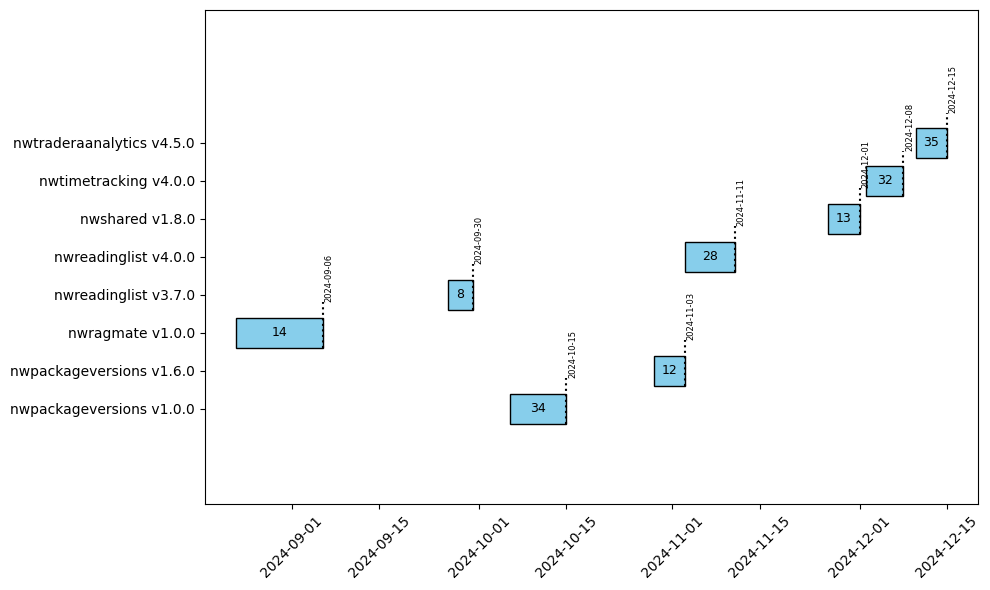

In [831]:
show_gantt_chart(df = tts_gantt_spnv_df)

In [832]:
def add_seq_rank(df : DataFrame, group_by : Literal[TTCN.HASHTAG] = TTCN.HASHTAG) -> DataFrame:

    '''
        Assigns sequential ranks to hashtags sorted by Date.

        Steps:
            1 -> [ "Date", "StartTime", "EndTime", "Effort", "Hashtag", "Descriptor", "IsSoftwareProject", "IsReleaseDay", "Year", "Month" ]
            2 -> ["Date", "Effort", "Hashtag"]
            3 -> ["Date", "Effort", "Hashtag", "SeqRank"]
    '''

    ranked_df : DataFrame = cast(DataFrame, df[[TTCN.DATE, TTCN.EFFORT, group_by]].copy(deep = True))
    ranked_df = ranked_df.sort_values(by = TTCN.DATE).reset_index(drop = True)

    hashtag_rank : dict[str, int] = {}
    current_seqrank : int = 1
    previous_hashtag : Optional[str] = None
    
    seq_ranks : list[int] = []

    for _, row in ranked_df.iterrows():

        current_hashtag: str = str(row[group_by])
        
        if current_hashtag != previous_hashtag:
            if current_hashtag not in hashtag_rank:
                hashtag_rank[current_hashtag] = current_seqrank
            else:
                hashtag_rank[current_hashtag] += 1
        
        seq_ranks.append(hashtag_rank[current_hashtag])

        previous_hashtag = current_hashtag
    
    ranked_df[TTCN.SEQRANK] = seq_ranks

    return ranked_df
def add_hashtag_seq(df : DataFrame) -> DataFrame:

    '''
        Expects: ["Date", "Effort", "Hashtag", "SeqRank"]
        Returns: ["Date", "Effort", "Hashtag", "SeqRank", "HashtagSeq"]
    '''

    hseq_df : DataFrame = cast(DataFrame, df[[TTCN.DATE, TTCN.EFFORT, TTCN.HASHTAG, TTCN.SEQRANK]].copy(deep = True))

    hseq_df[TTCN.HASHTAGSEQ] = hseq_df[TTCN.HASHTAG].astype(str) + hseq_df[TTCN.SEQRANK].astype(str)

    return hseq_df

df = tt_summary.tt_df
hseq_df = add_seq_rank(df = df)
hseq_df = add_hashtag_seq(df = hseq_df)

display(hseq_df)

,Date,Effort,Hashtag,SeqRank,HashtagSeq
0,2015-10-31,8h 00m,#untagged,1,#untagged1
1,2015-11-30,10h 00m,#untagged,1,#untagged1
2,2015-12-31,0h 00m,#untagged,1,#untagged1
3,2016-01-31,18h 00m,#untagged,1,#untagged1
4,2016-02-28,45h 30m,#untagged,1,#untagged1
...,...,...,...,...,...
1322,2024-12-16,10h 30m,#python,39,#python39
1323,2024-12-16,1h 30m,#python,39,#python39
1324,2024-12-17,3h 30m,#python,39,#python39
1325,2024-12-17,1h 00m,#python,39,#python39


In [833]:
tts_gantt_hseq_df : DataFrame= create_gannt_df(df = hseq_df, group_by = TTCN.HASHTAGSEQ)
tts_gantt_hseq_df = filter_by_from_start_date(df = tts_gantt_hseq_df, from_start_date = date(2024, 1, 1), sort_by = TTCN.HASHTAGSEQ)
tts_gantt_hseq_df = filter_by_duration(df = tts_gantt_hseq_df, min_duration = 10)

display(tts_gantt_hseq_df)


,HashtagSeq,StartDate,EndDate,EffortH,Duration
0,#python17,2024-02-27,2024-03-12,45,14
1,#python18,2024-03-15,2024-03-28,40,13
2,#python19,2024-04-16,2024-04-28,18,12
3,#python21,2024-05-19,2024-06-07,48,19
4,#python28,2024-08-31,2024-09-29,42,29
5,#python29,2024-09-30,2024-10-15,47,15
6,#studying74,2024-07-08,2024-07-26,34,18
7,#studying75,2024-07-30,2024-08-09,8,10


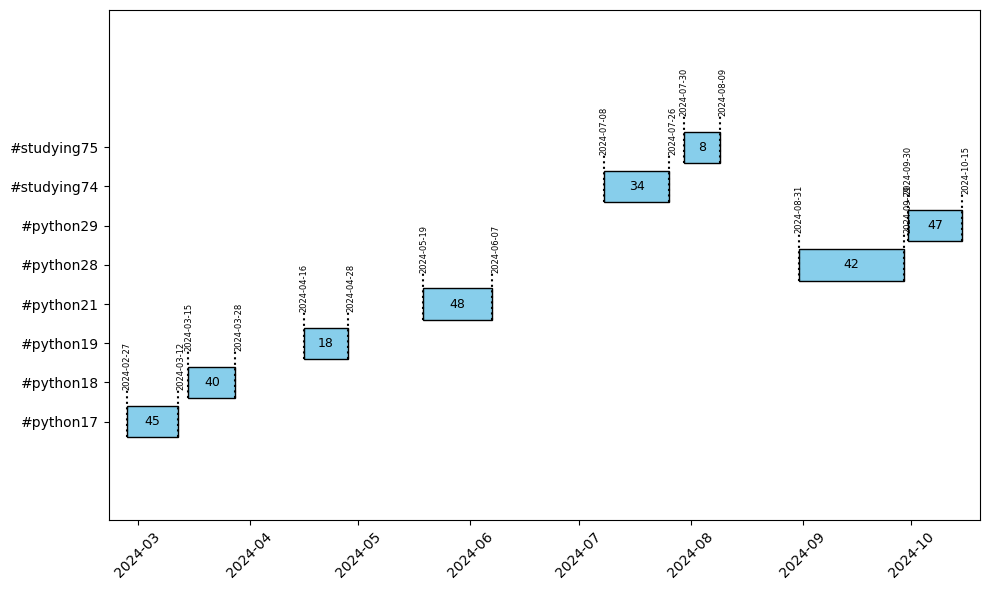

In [834]:
show_gantt_chart(df = tts_gantt_hseq_df, barh_y = TTCN.HASHTAGSEQ)